In [63]:
# https://fenicsproject.org/olddocs/dolfin/1.3.0/python/demo/documented/subdomains-poisson/python/documentation.html

In [1]:
from dolfin import *
%matplotlib inline
# Define input data
from ufl import SpatialCoordinate, inner, grad, lhs, rhs, dot, exp, Measure, dx, ds

In [2]:
import dolfin
dolfin.__version__

'2019.1.0'

In [3]:
# Create classes for defining parts of the boundaries and the interior
# of the domain
tol= 1E-15

class Left(SubDomain):
    def inside(self, x, on_boundary):
        return near(x[0], 0.0) and on_boundary

class Right(SubDomain):
    def inside(self, x, on_boundary):
        return near(x[0], 1.0) and on_boundary

class Bottom(SubDomain):
    def inside(self, x, on_boundary):
        return near(x[1], 0.0) and on_boundary

class Top(SubDomain):
    def inside(self, x, on_boundary):
        return near(x[1], 1.0) and on_boundary

class Obstacle(SubDomain):
    def inside(self, x, on_boundary):
        return (between(x[1], (0.5, 0.7)) and between(x[0], (0.2, 1 - tol)))

In [4]:
# Initialize sub-domain instances
left = Left()
top = Top()
right = Right()
bottom = Bottom()
obstacle = Obstacle()

In [5]:
# Define mesh
mesh = UnitSquareMesh(dolfin.MPI.comm_world,64, 64)

In [6]:
# Initialize mesh function for interior domains
domains = MeshFunction("size_t", mesh, mesh.topology().dim(),0)
obstacle.mark(domains, 1)

In [7]:
# Initialize mesh function for boundary domains
boundaries = MeshFunction("size_t", mesh, mesh.topology().dim() - 1,0)
left.mark(boundaries, 1)
top.mark(boundaries, 2)
right.mark(boundaries, 3)
bottom.mark(boundaries, 4)

In [8]:
# Define input data
a0 = Constant(1.0)
a1 = Constant(0.01)
x = SpatialCoordinate(mesh)
g_L = exp(- 10*(- pow(x[1] - 0.5, 2)))
#g_L = Expression("- 10*(- pow(x[1] - 0.5, 2))",degree=2)
g_R = Constant(1.0)
f = Constant(1.0)

In [9]:
# Define function space and basis functions
V = FunctionSpace(mesh, "CG", 2)
u = TrialFunction(V)
v = TestFunction(V)

In [10]:
# Define Dirichlet boundary conditions at top and bottom boundaries
bcs = [DirichletBC(V, 5.0, boundaries, 2),
       DirichletBC(V, 0.0, boundaries, 4)]

In [11]:
# Define new measures associated with the interior domains and
# exterior boundaries
dx = dx(subdomain_data=domains)
ds = ds(subdomain_data=boundaries)

In [12]:
# Define variational form
F = (inner(a0*grad(u), grad(v))*dx(0) + inner(a1*grad(u), grad(v))*dx(1)
     - g_L*v*ds(1) - g_R*v*ds(3)
     - f*v*dx(0) - f*v*dx(1))

In [13]:
# Separate left and right hand sides of equation
a, L = lhs(F), rhs(F)

In [14]:
# Solve problem
u = Function(V)
solve(a == L, u, bcs)

In [15]:
u(0.5,0.0)

-2.1624667638241798e-18

In [16]:
max(u.vector().vec().array)

5.3454073333474517

In [17]:
# Evaluate integral of normal gradient over top boundary
n = FacetNormal(mesh)
m1 = dot(grad(u), n)*ds(2)
v1 = assemble(m1)
print ("\int grad(u) * n ds(2) = ", v1)

\int grad(u) * n ds(2) =  -0.38523274518298223


In [18]:
# Evaluate integral of u over the obstacle
m2 = u*dx(1)
v2 = assemble(m2)
print ("\int u dx(1) = ", v2)

\int u dx(1) =  0.49165032237839285


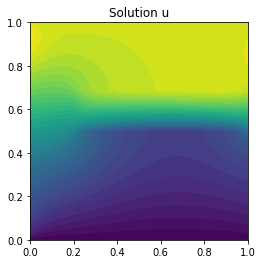

In [19]:
# Plot solution and gradient
plot(u, title="Solution u")

In [20]:
gu=grad(u)
gu

Grad(Coefficient(FunctionSpace(Mesh(VectorElement(FiniteElement('Lagrange', triangle, 1), dim=2), 0), FiniteElement('Lagrange', triangle, 2)), 15))

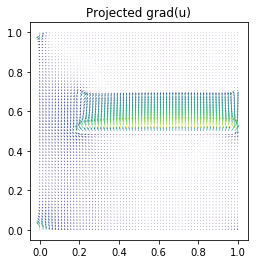

In [21]:
plot(gu, title="Projected grad(u)")

In [22]:
from numpy import linspace
from matplotlib.pyplot import plot

xval = linspace(0,1,10)

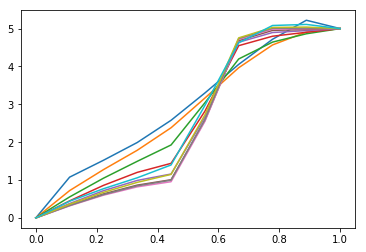

In [23]:
for x in xval:
    yval=[u(x, y) for y in xval]
    plot(xval, yval)